The strategy is a simple momentum strategy on the Nasdaq100 (it has suvivorship bias however).
Frequency: monthly
Rules: 
    -Every month calculate the top 50 stocks with the highest return over the past 12 months. Of those stocks, take the top 30 stocks with highest return over past 6 months. Of those stocks, invest in the top 10 stocks with highest return over past 3 months.
    - Equally weighted (1/10)
    - Costs = 50 bps per month (slippage, transaction costs,...)

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
#Pull in the Nasdaq100 tickers in a dataframe
#pd.read_html results in a list of dataframes with the dataframes representing the tables on the html page
ticker_df=pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]

In [3]:
#Select the ticker column and convert this series to a list so we have a list of tickers
#this is howver full of survivorship bias as it only includes tickers as of today
tickers=ticker_df['Ticker'].to_list()

In [4]:
#Pull daily price data for all the tickers: only adjusted close
#returns a Dataframe with index Date
start='1995-01-01'
df=yf.download(tickers,start=start)['Adj Close']
df.shape

[*********************100%***********************]  101 of 101 completed


(7094, 101)

In [5]:
#get daily returns in (1+R) format. Drop first line as Nan
#Then resample daily returns to monthly frequency by taking product of daily (1+R) to get a monthly return
mtl= (df.pct_change()+1)[1:].resample('M').prod()
mtl.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,AMZN,ANSS,ASML,ATVI,AVGO,AZN,BIIB,BKNG,BKR,CDNS,CEG,CHTR,CMCSA,COST,CPRT,CRWD,CSCO,CSGP,CSX,CTAS,CTSH,DDOG,DLTR,DXCM,EA,EBAY,ENPH,EXC,FANG,...,MCHP,MDLZ,MELI,META,MNST,MRNA,MRVL,MSFT,MU,NFLX,NVDA,NXPI,ODFL,ORLY,PANW,PAYX,PCAR,PDD,PEP,PYPL,QCOM,REGN,RIVN,ROST,SBUX,SGEN,SIRI,SNPS,TEAM,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-31 00:00:00-05:00,1.052117,1.0,0.980440,0.966292,1.012820,0.887658,1.064639,1.0,0.956521,1.175000,1.092275,1.0,1.0,1.000000,1.421054,1.0,1.021341,1.078947,1.0,0.985419,1.114650,1.0,1.0,0.951219,1.067961,1.057145,1.0,0.978022,1.0,1.012367,0.965035,1.0,1.0,1.000000,1.0,0.937705,1.0,1.0,1.080808,1.0,...,0.850357,1.0,1.0,1.0,1.034507,1.0,1.0,0.986500,1.011428,1.0,1.0,1.0,1.030302,1.063830,1.0,0.992696,0.971751,1.0,1.024306,1.0,1.092783,2.000000,1.0,1.023811,0.897196,1.0,1.705882,1.008357,1.0,1.0,1.0,0.938776,1.0,1.033333,1.061452,1.0,1.0,1.045198,1.0,1.0
1995-02-28 00:00:00-05:00,0.981020,1.0,1.235421,1.168605,1.040085,1.184906,0.984378,1.0,1.198053,1.034043,1.084479,1.0,1.0,1.000000,1.043982,1.0,0.988060,1.463416,1.0,1.085107,1.171429,1.0,1.0,1.095524,0.990909,1.020269,1.0,1.011236,1.0,1.091754,1.101449,1.0,1.0,1.000000,1.0,1.202797,1.0,1.0,1.015300,1.0,...,1.128491,1.0,1.0,1.0,1.033331,1.0,1.0,1.061053,1.401130,1.0,1.0,1.0,1.044118,1.060000,1.0,1.051281,1.029311,1.0,1.061016,1.0,1.103774,0.943396,1.0,1.087207,0.994792,1.0,1.137931,1.044199,1.0,1.0,1.0,1.141304,1.0,1.048387,0.998816,1.0,1.0,0.978378,1.0,1.0
1995-03-31 00:00:00-05:00,0.892404,1.0,1.385995,1.014926,1.024733,1.073248,0.937269,1.0,1.195121,1.115226,0.976449,1.0,1.0,1.250000,0.851441,1.0,1.049552,1.000000,1.0,1.065359,1.034146,1.0,1.0,0.972656,1.082569,1.006622,1.0,1.129630,1.0,1.012861,0.991995,1.0,1.0,1.154930,1.0,1.052326,1.0,1.0,0.939253,1.0,...,1.113862,1.0,1.0,1.0,0.838697,1.0,1.0,1.128968,1.229389,1.0,1.0,1.0,0.901408,0.976415,1.0,1.121952,0.965909,1.0,1.004652,1.0,1.119658,1.000000,1.0,0.945957,1.005235,1.0,0.954545,1.010582,1.0,1.0,1.0,1.126798,1.0,0.830769,1.018519,1.0,1.0,0.972376,1.0,1.0
1995-04-30 00:00:00-04:00,1.085107,1.0,1.176768,1.053921,1.019841,0.809759,1.031496,1.0,1.117914,1.062731,1.078850,1.0,1.0,0.973333,0.979166,1.0,1.029498,1.066667,1.0,1.104294,1.207547,1.0,1.0,1.000000,0.991525,1.072369,1.0,1.045901,1.0,1.012699,1.026667,1.0,1.0,1.097561,1.0,1.016575,1.0,1.0,1.024875,1.0,...,1.004444,1.0,1.0,1.0,0.923081,1.0,1.0,1.149385,1.083744,1.0,1.0,1.0,1.000000,1.033816,1.0,1.037401,1.082353,1.0,1.063898,1.0,0.801527,1.020000,1.0,0.886366,0.979167,1.0,1.000000,1.136126,1.0,1.0,1.0,1.197741,1.0,1.055556,0.976623,1.0,1.0,1.020997,1.0,1.0
1995-05-31 00:00:00-04:00,1.089615,1.0,0.892704,1.158139,0.968872,1.086238,1.065395,1.0,1.249492,0.916667,0.997420,1.0,1.0,1.178082,1.063830,1.0,1.031519,1.124999,1.0,1.004998,0.933594,1.0,1.0,1.118040,0.965812,1.030675,1.0,1.097179,1.0,0.961662,0.896104,1.0,1.0,1.000000,1.0,1.119565,1.0,1.0,1.108788,1.0,...,1.053098,1.0,1.0,1.0,0.916672,1.0,1.0,1.035932,1.082992,1.0,1.0,1.0,0.859375,0.971963,1.0,0.929134,1.051881,1.0,1.177177,1.0,0.976191,0.960784,1.0,1.089741,1.236703,1.0,0.952381,1.000000,1.0,1.0,1.0,1.090802,1.0,1.105263,1.028146,1.0,1.0,1.070622,1.0,1.0


In [6]:
#function that calculates the 12M,6M and 3M returns
def get_rolling_ret(df,n):
    """Calculate a rolling cumulative return for a given time window.
    Args:
        df(DataFrame): DataFrame with monthly returns of stocks in (1+R) format.
        n(int): Time window to calculate the cumulative return.
    Returns:
        DataFrame: DataFrame with returns for a given time window in (1+R)-format for
        each month.
    """
    return df.rolling(n).apply(np.prod)

In [7]:
#Create 3 DataFrames with 12M rolling returns, 6M rolling returns and 3M rolling returns
ret_12,ret_6,ret_3=get_rolling_ret(mtl,12),get_rolling_ret(mtl,6),get_rolling_ret(mtl,3)

In [8]:
#create a function that returns the top tickers for a given date
def get_top(date):
    """ Calculate top 10 ticker symbols for a given date.
    Args:
        date(str): date
    Returns:
        Index objecct: with list of tickers
    """   
    top_50=ret_12.loc[date].nlargest(50).dropna().index
    top_30=ret_6.loc[date,top_50].nlargest(30).dropna().index
    top_10=ret_3.loc[date,top_30].nlargest(10).dropna().index
    return top_10

In [9]:
#Before we create a function in next cell, an example. How did this portfolio perform for portfolio formed at given date and held for one month
#Example: for top-10 tickers find the monthly returns starting for a given date
mtl.loc['2010-12-31':,get_top('2010-12-31')]
#only get that one month return after that date
portfolio=mtl.loc['2010-12-31':,get_top('2010-12-31')][1:2]
#get the portfolio return (equally weighted)
portfolio.mean(axis=1).values[0]

1.0802359124760448

In [10]:
#Create a function that gives us - for a given date - the portfolio return of top-10 stocks that were held for one month 
#after formation date.
def pf_performance(date):
    """Calculate 1-month portfolio performance of the top-10 stocks after formation date.
    Args:
        date(str): formation date
    Returns:
        float: portfolio performance (equally weighted 1/10) in (1+R) format.
    """
    portfolio=mtl.loc[date:,get_top(date)][1:2]
    return portfolio.mean(axis=1).values[0]

In [11]:
#test of function
pf_performance('2010-12-31')

1.0802359124760448

In [12]:
#Create the monhtly portfolio return series for all portfolio formation dates  with a loop
returns=[]
for date in mtl.index[:-1]:
    returns.append(pf_performance(date))
#convert list to series with 50 bps costs per month (slippage, transactions,...)
Return_series=pd.Series([i-0.005 for i in returns],index=mtl.index[1:])

<AxesSubplot: xlabel='Date'>

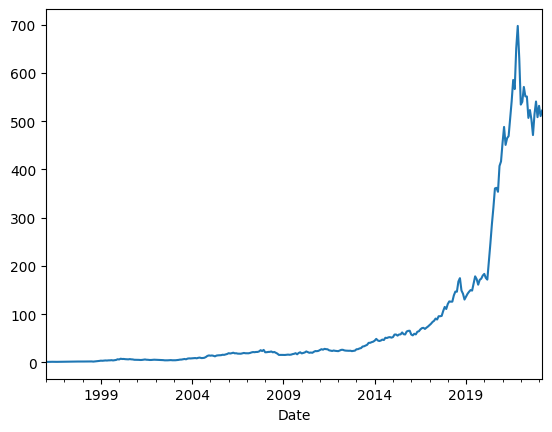

In [13]:
#Calculate the cumulative return for the strategy 
Strat_cum=Return_series.cumprod()[11:]
Strat_cum.plot()

In [14]:
#Benchmark download for performance comparison
bench_df=yf.download('^IXIC',start=start)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [15]:
bench_daily=(bench_df.pct_change()+1)[2:]
bench_mtly=bench_daily.resample('M').prod()[12:]
Bench_cum=bench_mtly.cumprod()

In [16]:
#Relative performance
Rel=Strat_cum/Bench_cum

In [17]:
#Drawdowns Strategy
Strat_max=Strat_cum.cummax()
Strat_dd=Strat_cum/Strat_max-1
#Drawdowns Index
Bench_max=Bench_cum.cummax()
Bench_dd=Bench_cum/Bench_max-1

In [18]:
YearFraq=Strat_cum.shape[0]/12
#Annualized Returns
Strat_ar=(Strat_cum[-1]-1)**(1/YearFraq)-1
Bench_ar=(Bench_cum[-1]-1)**(1/YearFraq)-1
#AnnualizedVol
Strat_vol=Return_series.std()*np.sqrt(12)
Bench_vol=bench_mtly.std()*np.sqrt(12)
#Sharpe
Strat_sharpe=Strat_ar/Strat_vol
Bench_sharpe=Bench_ar/Bench_vol
#MaxDrawdown
Strat_md=min(Strat_dd)
Bench_md=min(Bench_dd)
#Return/MaxDrawdown
Strat_r_to_md=Strat_ar/abs(Strat_md)
Bench_r_to_md=Bench_ar/abs(Bench_md)
#Put Everything in DataFrame
Output_dict={'Performance Metrics':['CAGR%','Volatility','CAGR/Vol','Max Drawdown %','CAGR/MaxDrawdown'],
        'Strategy':['{:.2f}%'.format(Strat_ar*100),'{:.2f}%'.format(Strat_vol*100),'{:.2f}'.format(Strat_sharpe),'{:.2f}%'.format(Strat_md*100),'{:.2f}'.format(Strat_r_to_md)],
        'Benchmark':['{:.2f}%'.format(Bench_ar*100),'{:.2f}%'.format(Bench_vol*100),'{:.2f}'.format(Bench_sharpe),'{:.2f}%'.format(Bench_md*100),'{:.2f}'.format(Bench_r_to_md)]}

start=Strat_cum.index[0].strftime("%Y-%m")
end = Strat_cum.index[-1].strftime("%Y-%m")

Metrics=pd.DataFrame(Output_dict)
Metrics=Metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
Metrics

,Performance Metrics ( 1996-01 till 2023-03),Strategy,Benchmark
0,CAGR%,25.81%,8.82%
1,Volatility,25.07%,22.74%
2,CAGR/Vol,1.03,0.39
3,Max Drawdown %,-44.11%,-75.04%
4,CAGR/MaxDrawdown,0.59,0.12


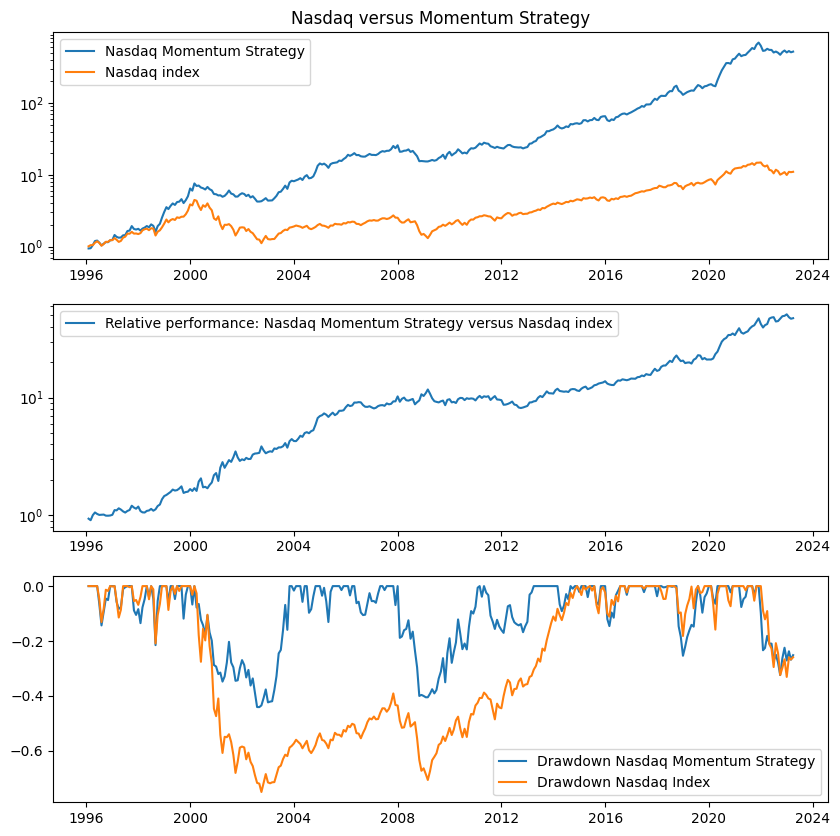

In [19]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Nasdaq versus Momentum Strategy")
ax[0].semilogy(Strat_cum,label="Nasdaq Momentum Strategy")
ax[0].semilogy(Bench_cum,label="Nasdaq index")
ax[0].legend()
ax[1].semilogy(Rel,label="Relative performance: Nasdaq Momentum Strategy versus Nasdaq index")
ax[1].legend()
ax[2].plot(Strat_dd,label='Drawdown Nasdaq Momentum Strategy')
ax[2].plot(Bench_dd,label='Drawdown Nasdaq Index')
ax[2].legend()

In [20]:
#put series into csv

Strat_cum.to_csv('strategy_cumulative.csv')

In [22]:
get_top('2023-02-28')

Index(['SGEN', 'NVDA', 'MELI', 'BKNG', 'ODFL', 'CDNS', 'FISV', 'AVGO', 'ADI',
       'PDD'],
      dtype='object')

In [23]:
Strat_cum.tail()

Date
2022-11-30 00:00:00-05:00    540.879322
2022-12-31 00:00:00-05:00    508.448087
2023-01-31 00:00:00-05:00    531.895774
2023-02-28 00:00:00-05:00    510.557870
2023-03-31 00:00:00-04:00    522.001653
Freq: M, dtype: float64